## Political Alignment and Polarization


This is the second in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/). This case study is part of the [Elements of Data Science](https://allendowney.github.io/ElementsOfDataScience/) curriculum.

In this notebook and in the next one we make up a case study that uses data from the General Social Survey (GSS) to explore political beliefs and political alignment (conservative, moderate, or liberal) in the United States.

Here we:

1. Compare the distributions of political alignment from 1974 and 2021.
2. Plot the mean and standard deviation of responses over time as a way of quantifying shifts in political alignment and polarization.
3. Use local regression to plot a smooth line through noisy data.
4. Use cross tabulation to compute the fraction of respondents in each category over time.
5. Plot the results using a custom color palette.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

### Loading the data

In the previous notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in and HDF file, which is much faster to load. In this and the following notebooks we'll load the HDF file.

In [2]:
datafile = "../data/gss_pacs_2022_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(72390, 207)

### Political Alignment

The people surveyed as part of the GSS were asked about their "political alignment", which is where they place themselves on a spectrum from liberal to conservative.

The variable `polviews` contains responses to the following question (see https://gssdataexplorer.norc.org/variables/178/vshow):

> We hear a lot of talk these days about liberals and conservatives. I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

Here are the valid responses:

|   |                        |
|---|------------------------|
| 1 | Extremely liberal      |
| 2 | Liberal                |
| 3 | Slightly liberal       |
| 4 | Moderate               |
| 5 | Slghtly conservative   |
| 6 | Conservative           |
| 7 | Extremely conservative |
| 8 | Don't know             |
| 9 | No answer              |
| 0 | Not applicable         |

To see how the responses have changed over time, we'll inspect them at the beginning and end of the observation period.

First we'll select the column.

In [3]:
polviews = gss["polviews"]

Then we can compute a boolean series that's `True` for responses from 1974.

In [4]:
year74 = gss["year"] == 1974

Now we can select the responses from 1974.

In [5]:
polviews74 = polviews[year74]

We'll use the following function to count the number of times each response occurs.

In [6]:
def values(series):
    """Count the values and sort.

    series: pd.Series

    returns: series mapping from values to frequencies.
    """
    return series.value_counts().sort_index()

Here are the responses from 1974.

In [7]:
values(polviews74)

polviews
1.0     31
2.0    201
3.0    211
4.0    538
5.0    223
6.0    181
7.0     30
Name: count, dtype: int64

And here are the reponses from 2021.

In [8]:
year21 = gss["year"] == 2021
polviews21 = polviews[year21]
values(polviews21)

polviews
1.0     212
2.0     577
3.0     427
4.0    1506
5.0     480
6.0     569
7.0     181
Name: count, dtype: int64

Looking at a table of counts, we can get a sense of what the distribution looks like, but in the next section we'll get a better sense by plotting it.

### Visualizing Distributions

To visualize these distributions, we'll use a Probability Mass Function (PMF), which is similar to histogram, but there are two differences:

* In a histogram, values are often put in bins, with more than one value in each bin. In a PMF each value gets its own bin.
* A histogram computes a count, that is, how many times each value appears; a PMF computes a probability, that is, what fraction of the time each value appears.

We'll use `Pmf` class from `empiricaldist` to compute a PMF.

In [9]:
pmf74 = Pmf.from_seq(polviews74)
pmf74

,probs
polviews,
1.0,0.021908
2.0,0.142049
3.0,0.149117
4.0,0.380212
5.0,0.157597
6.0,0.127915
7.0,0.021201


The following cell defines a function I use to decorate the axes in plots.

In [10]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
            xlabel='x',
            ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

Here's the distribution from 1974:

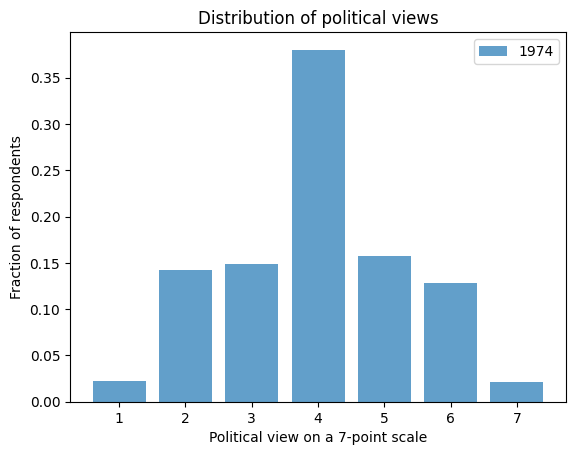

In [11]:
pmf74.bar(label="1974", color="C0", alpha=0.7)

decorate(
    xlabel="Political view on a 7-point scale",
    ylabel="Fraction of respondents",
    title="Distribution of political views",
)

And from 2021:

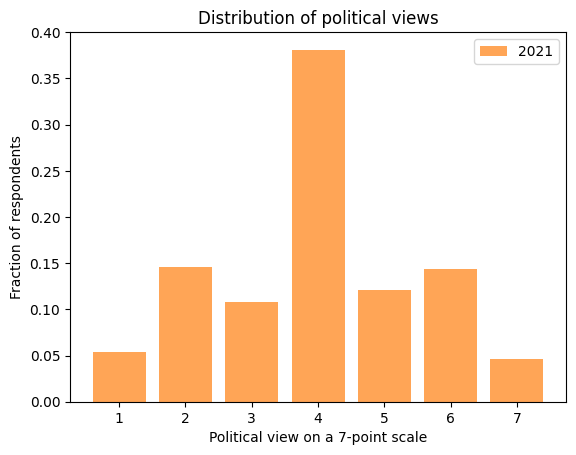

In [12]:
pmf21 = Pmf.from_seq(polviews21)
pmf21.bar(label="2021", color="C1", alpha=0.7)

decorate(
    xlabel="Political view on a 7-point scale",
    ylabel="Fraction of respondents",
    title="Distribution of political views",
)

In both cases, the most common response is `4`, which is the code for "moderate". Few respondents describe themselves as "extremely" liberal or conservative. So maybe we're not so polarized after all.

To make it easier to compare distributions, I'll plot them side by side.

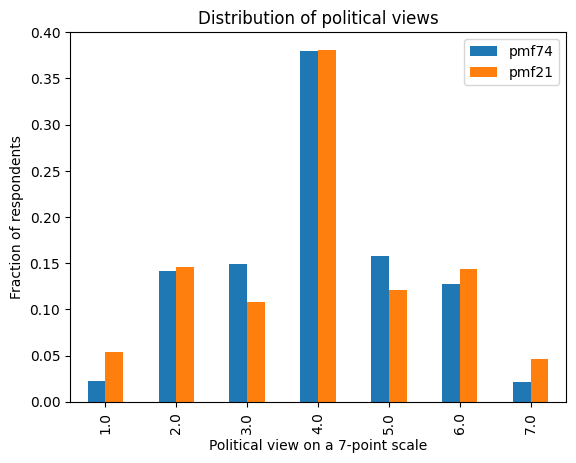

In [13]:
d = dict(pmf74=pmf74, pmf21=pmf21)

df = pd.DataFrame(d)
df.plot(kind="bar")

decorate(
    xlabel="Political view on a 7-point scale",
    ylabel="Fraction of respondents",
    title="Distribution of political views",
)

Now we can see the changes in the distribution more clearly. It looks like the number of people at the extremes (1 and 7) has increased, and the fraction of slightly liberal (3) and slightly conservative (5) has decreased.

To summarize these changes, we can compare the mean and standard deviation of `polviews` in 1974 and 2021.

The mean of the responses measures the balance of people in the population with liberal or conservative leanings. If the mean increases over time, that might indicate a shift in the population toward conservatism.

The standard deviation measures the dispersion of views in the population; if it increases over time, that might indicate an increase in polarization.

In [24]:
print(f"1974 -> mean: {polviews74.mean()}, std: {polviews74.std()}")
print(f"2021 -> mean: {polviews21.mean()}, std: {polviews21.std()}")

1974 -> mean: 3.9780918727915195, std: 1.3324162225592249
2021 -> mean: 3.98582995951417, std: 1.5115522818003158


The mean has barely changed, which indicates no net shift toward liberal or conservate identity.

The standard deviation has increased, which suggests increased polarization.

### Plotting a Time Series

At this point we have looked at the endpoints, 1974 and 2021, but we don't know what happened in between. To see how the distribution changed over time, we can group by year and compute the mean of `polviews` during each year. We can use `groupby` to group the repondents by year.

In [25]:
gss_by_year = gss.groupby("year")
gss_by_year

The result is a `DataFrameGroupBy` object that represents a collection of groups.

We can loop through the groups and display the number of respondents in each:

In [26]:
for year, group in gss_by_year:
    print(year, len(group))

1972 1613
1973 1504
1974 1484
1975 1490
1976 1499
1977 1530
1978 1532
1980 1468
1982 1860
1983 1599
1984 1473
1985 1534
1986 1470
1987 1819
1988 1481
1989 1537
1990 1372
1991 1517
1993 1606
1994 2992
1996 2904
1998 2832
2000 2817
2002 2765
2004 2812
2006 4510
2008 2023
2010 2044
2012 1974
2014 2538
2016 2867
2018 2348
2021 4032
2022 3544


In many ways the `DataFrameGroupBy` behaves like a `DataFrame`. We can use the bracket operator to select a column:

In [27]:
polviews_by_year = gss_by_year["polviews"]
polviews_by_year

A column from a `DataFrameGroupBy` is a `SeriesGroupBy`. If we evoke `mean` on it, the result is a series that contains the mean of `polviews` for each year of the survey.

In [28]:
mean_series = polviews_by_year.mean()

And here what it looks like.

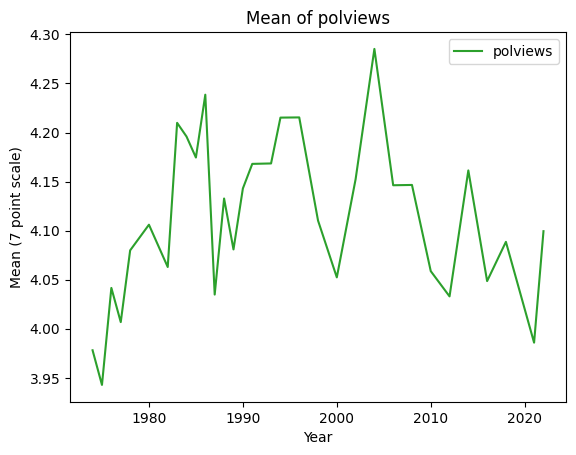

In [30]:
mean_series.plot(color="C2", label="polviews")
decorate(xlabel="Year", ylabel="Mean (7 point scale)", title="Mean of polviews")

It looks like the mean increased between 1974 and 2000, decreased since then, and ended up almost where it started. The difference between the highest and lowest points is only 0.3 on a 7-point scale, which is a modest effect.

In [32]:
print(mean_series.max() - mean_series.min())

0.34240143126104083


The standard deviation quantifies the spread of the distribution, which is one way to measure polarization. Below is a plot of the standard deviation of `polviews` for each year of the survey from 1972 to 2021.

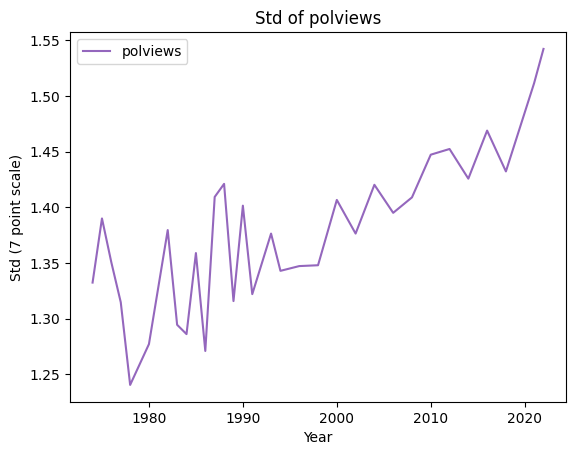

In [34]:
std_series = polviews_by_year.std()
std_series.plot(color="C4", label="polviews")
decorate(xlabel="Year", ylabel="Std (7 point scale)", title="Std of polviews")

The standard deviation has increased consistently over the entire interval. But the difference between the highest and lowest points is small. So if polarization is increasing, it is not a recent phenomenon, and it is not changing quickly.

In [35]:
print(std_series.max() - std_series.min())

0.3019236519298678


### Smoothing the curve

In the previous section we plotted mean and standard deviation of `polviews` over time. In both plots, the values are highly variable from year to year. We can use **local regression** to compute a smooth line through these data points.

The following function takes a Pandas Series and uses an algorithm called LOWESS to compute a smooth line. LOWESS stands for "locally weighted scatterplot smoothing".

In [36]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

We'll use the following function to plot data points and the smoothed line.

In [37]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker="o", color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label="", color=color)

The following figure shows the mean of `polviews` and a smooth line.

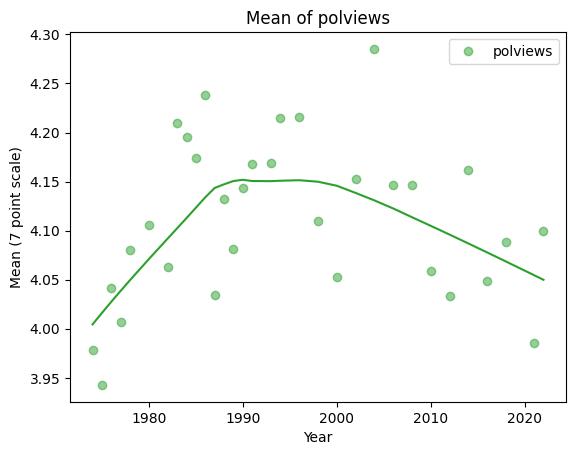

In [38]:
mean_series = gss_by_year["polviews"].mean()
plot_series_lowess(mean_series, "C2")
decorate(ylabel="Mean (7 point scale)", title="Mean of polviews", xlabel="Year")

One reason the PMFs for 1974 and 2021 did not look very different is that the mean seems to have gone up (more conservative) and then down again (more liberal). Generally, it looks like the U.S. has been trending toward liberal for the last 20 years, or more, at least in the sense of how people describe themselves.

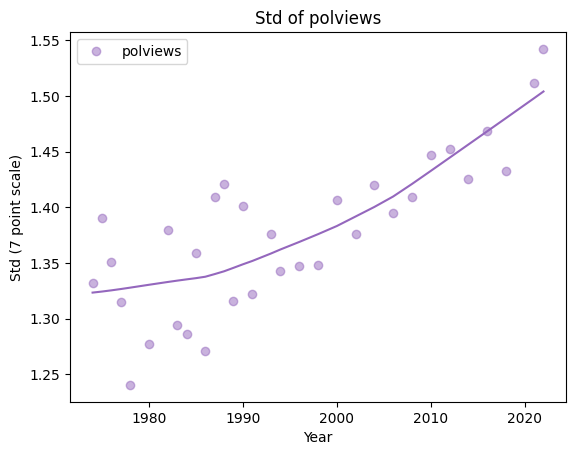

In [40]:
std_series = gss_by_year["polviews"].std()
plot_series_lowess(std_series, "C4")
decorate(ylabel="Std (7 point scale)", title="Std of polviews", xlabel="Year")

### Cross tabulation

In the previous sections, we treated `polviews` as a numerical quantity, so we were able to compute means and standard deviations. But the responses are really categorical, which means that each value represents discrete category like "liberal" or "conservative". In this section, we'll treat `polviews` as a categorical variable. Specifically, we'll compute the number of respondents in each category for each year, and plot changes over time.

Pandas provides a function called `crosstab` that computes a **cross tabulation**, which is like a two-dimensional PMF. It takes two `Series` objects as arguments and returns a `DataFrame`.

In [41]:
year = gss["year"]
column = gss["polviews"]

xtab = pd.crosstab(year, column)

Here are the first few lines from the result.

In [42]:
xtab.head()

polviews,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,
1974,31,201,211,538,223,181,30
1975,56,184,207,540,204,162,45
1976,31,198,175,564,209,206,34
1977,37,181,214,594,243,164,42
1978,21,140,255,559,265,187,25


It contains one row for each value of `year` and one column for each value of `polviews`. Reading the first row, we see that in 1974, 31 people gave response 1, "extremely liberal", 201 gave response 2, "liberal", and so on.

The number of respondents varies from year to year, so we need to normalize the results, which means computing for each year the *fraction* of respondents in each category, rather than the count.

`crosstab` takes an optional argument that normalizes each row.

In [43]:
xtab_norm = pd.crosstab(year, column, normalize="index")

Here's what that looks like for the 7-point scale.

In [44]:
xtab_norm.head()

polviews,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,
1974,0.021908,0.142049,0.149117,0.380212,0.157597,0.127915,0.021201
1975,0.040057,0.131617,0.148069,0.386266,0.145923,0.115880,0.032189
1976,0.021877,0.139732,0.123500,0.398024,0.147495,0.145378,0.023994
1977,0.025085,0.122712,0.145085,0.402712,0.164746,0.111186,0.028475
1978,0.014463,0.096419,0.175620,0.384986,0.182507,0.128788,0.017218


Looking at the numbers in the table, it's hard to see what's going on. In the next section, we'll plot the results.

To make the results easier to interpret, I'm going to replace the numeric codes 1-7 with strings. First I'll make a dictionary that maps from numbers to strings:

In [45]:
# recode the 7 point scale with words

d7 = {
    1: "Extremely liberal",
    2: "Liberal",
    3: "Slightly liberal",
    4: "Moderate",
    5: "Slightly conservative",
    6: "Conservative",
    7: "Extremely conservative",
}

Then we can use the `replace` function like this:

In [46]:
polviews7 = gss["polviews"].replace(d7)

We can use `values` to confirm that the values in `polviews7` are strings.

In [47]:
values(polviews7)

polviews
Conservative               9612
Extremely conservative     2145
Extremely liberal          2095
Liberal                    7309
Moderate                  24157
Slightly conservative      9816
Slightly liberal           7799
Name: count, dtype: int64

If we make the cross tabulation again, we can see that the column names are strings.

In [48]:
xtab_norm = pd.crosstab(year, polviews7, normalize="index")
xtab_norm.head()

polviews,Conservative,Extremely conservative,Extremely liberal,Liberal,Moderate,Slightly conservative,Slightly liberal
year,,,,,,,
1974,0.127915,0.021201,0.021908,0.142049,0.380212,0.157597,0.149117
1975,0.115880,0.032189,0.040057,0.131617,0.386266,0.145923,0.148069
1976,0.145378,0.023994,0.021877,0.139732,0.398024,0.147495,0.123500
1977,0.111186,0.028475,0.025085,0.122712,0.402712,0.164746,0.145085
1978,0.128788,0.017218,0.014463,0.096419,0.384986,0.182507,0.175620


### Color palettes

Seaborn provides a variety of color palettes, [which you can read about here.](https://seaborn.pydata.org/tutorial/color_palettes.html)

To represent political views, I'll use a diverging palette from blue to red.

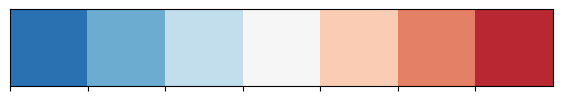

In [50]:
palette = sns.color_palette("RdBu_r", 7)
sns.palplot(palette)

Here's the modified diverging palette with purple in the middle.

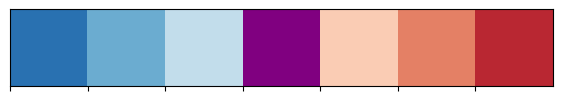

In [51]:
palette[3] = "purple"
sns.palplot(palette)

A feature of this color map is that the colors are meaningful, at least in countries that use blue, purple, and red for these points on the political spectrum. A drawback of this color map is that some some of the colors are indistinguishable to people who are [color blind.](https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)

Now I'll make a dictionary that maps from the responses to the corresponding colors.

In [52]:
columns = [
    "Extremely liberal",
    "Liberal",
    "Slightly liberal",
    "Moderate",
    "Slightly conservative",
    "Conservative",
    "Extremely conservative",
]

In [53]:
color_map = dict(zip(columns, palette))

for key, value in color_map.items():
    print(key, value)

Extremely liberal (0.16339869281045757, 0.44498269896193776, 0.6975009611687812)
Liberal (0.4206843521722416, 0.6764321414840447, 0.8186851211072664)
Slightly liberal (0.7614763552479817, 0.8685121107266438, 0.924567474048443)
Moderate purple
Slightly conservative (0.9824682814302191, 0.8006920415224913, 0.7061130334486736)
Conservative (0.8945790080738177, 0.5038062283737024, 0.39976931949250283)
Extremely conservative (0.7284890426758939, 0.15501730103806227, 0.1973856209150327)


### Plotting a cross tabulation

To see how the fraction of people with each political alignment has changed over time, we'll use `plot_series_lowess` to plot the columns from `xtab_norm`.

Here are the 7 categories plotted as function of time. The `bbox_to_anchor` argument passed to `plt.legend` puts the legend outside the axes of the figure.

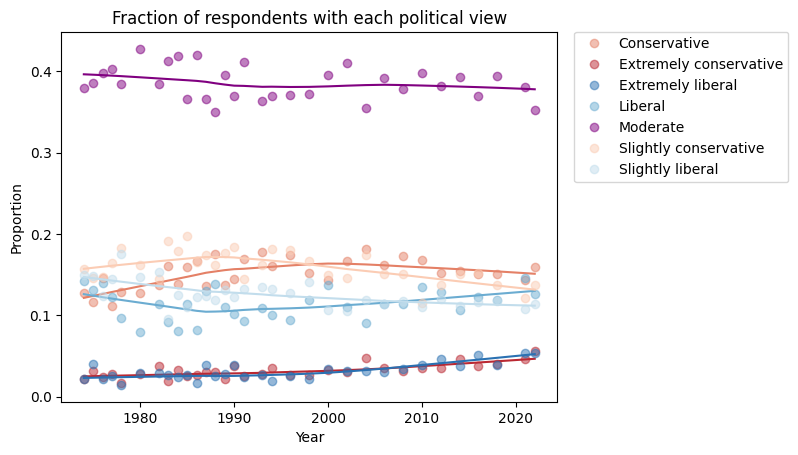

In [54]:
for name, column in xtab_norm.items():
    plot_series_lowess(column, color_map[name])

decorate(
    xlabel="Year",
    ylabel="Proportion",
    title="Fraction of respondents with each political view",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))

This way of looking at the results suggests that changes in political alignment during this period have generally been slow and small. The fraction of self-described moderates has not changed substantially. The fraction of conservatives increased, but seems to be decreasing now; the number of liberals seems to be increasing.

The fraction of people at the extremes has increased, but it is hard to see clearly in this figure. We can get a better view by plotting just the extremes.

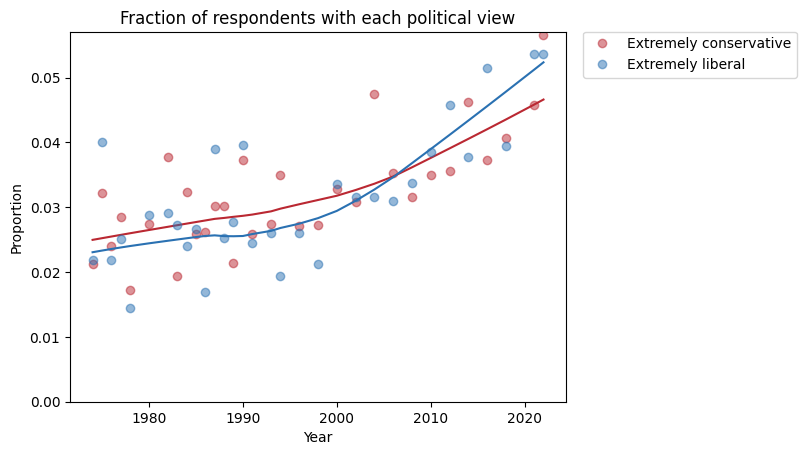

In [56]:
selected_columns = ["Extremely liberal", "Extremely conservative"]

for name, column in xtab_norm.items():
    if name not in selected_columns:
        continue
    plot_series_lowess(column, color_map[name])

decorate(
    xlabel="Year",
    ylabel="Proportion",
    ylim=[0, 0.057],
    title="Fraction of respondents with each political view",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))

I used `ylim` to set the limits of the y-axis so it starts at zero, to avoid making the changes seem bigger than they are.

This figure shows that the fraction of people who describe themselves as "extreme" has increased from about 2.5% to about 5%. In relative terms, that's a big increase. But in absolute terms these tails of the distribution are still small.

Let's do a similar analysis with `partyid`, which encodes responses to the question:

> Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?

The valid responses are:

|   |                        |
|---|------------------------|
| 0 | Strong democrat      |
| 1 | Not str democrat                |
| 2 | Ind,near dem               |
| 3 | Independent   |
| 4 | Ind,near rep           |
| 5 | Not str republican |
| 6 | Strong republican             |
| 7 | Other party              |

In [64]:
partyid_column = gss["partyid"]
xtab_partyid_norm = pd.crosstab(year, partyid_column, normalize="index")
xtab_partyid_norm.head()

partyid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,,
1972,0.212197,0.278780,0.091475,0.090853,0.052271,0.155569,0.082141,0.036714
1973,0.151576,0.249497,0.130785,0.093897,0.094567,0.153588,0.067740,0.058350
1974,0.187629,0.270790,0.118900,0.089347,0.070103,0.139519,0.076976,0.046735
1975,0.174089,0.238192,0.125506,0.128205,0.078947,0.174089,0.074224,0.006748
1976,0.137032,0.265374,0.157754,0.161096,0.087567,0.135027,0.054144,0.002005


In [63]:
partyid_d7 = {
    0: "Strong democrat",
    1: "Not str democrat",
    2: "Ind,near dem",
    3: "Independent",
    4: "Ind,near rep",
    5: "Not str republican",
    6: "Strong republican",
    7: "Other party",
}

partyid7 = gss["partyid"].replace(partyid_d7)
values(partyid7)

partyid
Ind,near dem           8376
Ind,near rep           6740
Independent           11510
Not str democrat      14360
Not str republican    10875
Other party            1307
Strong democrat       11250
Strong republican      7446
Name: count, dtype: int64

In [65]:
xtab_partyid_norm = pd.crosstab(year, partyid7, normalize="index")
xtab_partyid_norm.head()

partyid,"Ind,near dem","Ind,near rep",Independent,Not str democrat,Not str republican,Other party,Strong democrat,Strong republican
year,,,,,,,,
1972,0.091475,0.052271,0.090853,0.278780,0.155569,0.036714,0.212197,0.082141
1973,0.130785,0.094567,0.093897,0.249497,0.153588,0.058350,0.151576,0.067740
1974,0.118900,0.070103,0.089347,0.270790,0.139519,0.046735,0.187629,0.076976
1975,0.125506,0.078947,0.128205,0.238192,0.174089,0.006748,0.174089,0.074224
1976,0.157754,0.087567,0.161096,0.265374,0.135027,0.002005,0.137032,0.054144


In [72]:
partyid_columns = [
    "Strong democrat",
    "Not str democrat",
    "Ind,near dem",
    "Independent",
    "Ind,near rep",
    "Not str republican",
    "Strong republican",
]

color_map = dict(zip(partyid_columns, palette))

for key, value in color_map.items():
    print(key, value)

Strong democrat (0.16339869281045757, 0.44498269896193776, 0.6975009611687812)
Not str democrat (0.4206843521722416, 0.6764321414840447, 0.8186851211072664)
Ind,near dem (0.7614763552479817, 0.8685121107266438, 0.924567474048443)
Independent purple
Ind,near rep (0.9824682814302191, 0.8006920415224913, 0.7061130334486736)
Not str republican (0.8945790080738177, 0.5038062283737024, 0.39976931949250283)
Strong republican (0.7284890426758939, 0.15501730103806227, 0.1973856209150327)


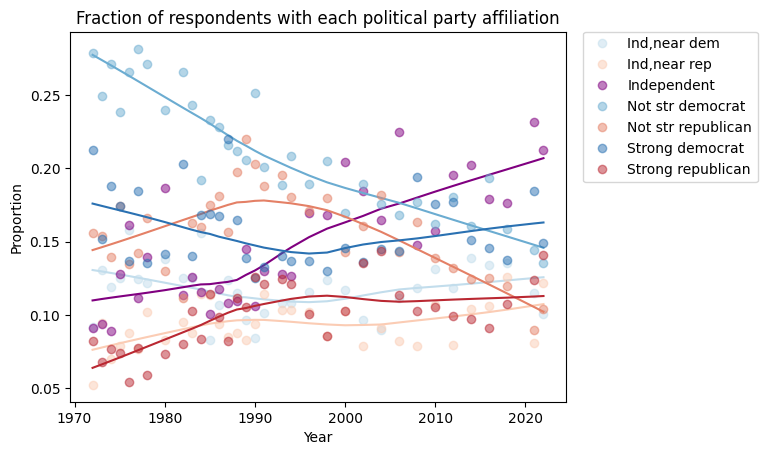

In [74]:
xtab_partyid_norm.drop("Other party", inplace=True, axis="columns")

for name, column in xtab_partyid_norm.items():
    plot_series_lowess(column, color_map[name])

decorate(
    xlabel="Year",
    ylabel="Proportion",
    title="Fraction of respondents with each political party affiliation",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
None

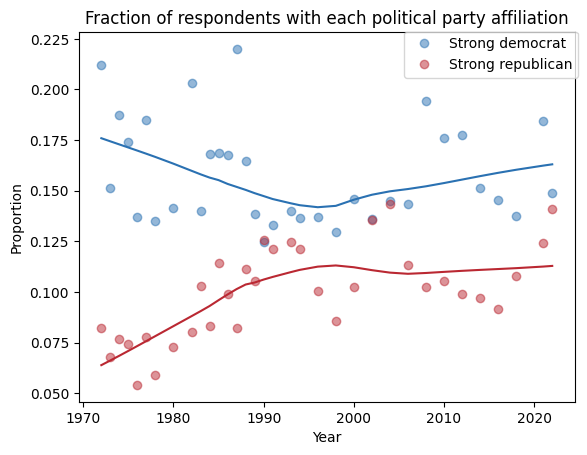

In [76]:
selected_columns = [
    "Strong democrat",
    "Strong republican",
]

for name, column in xtab_partyid_norm.items():
    if name not in selected_columns:
        continue
    plot_series_lowess(column, color_map[name])

decorate(
    xlabel="Year",
    ylabel="Proportion",
    title="Fraction of respondents with each political party affiliation",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
None